# Modelling flow through the homeless services system with a DES model in SimPy (Python)

The DES model of flow through the homeless services system (Singham et al. (2023) illustrates the effects of different development plans (building a mix of temporary shelter and permanent accommodation) on the homeless population involved. This model was built in Simio. We here present a Python DES model of the aggregated version of the model. The motivation for a Python version is two-fold: 

* to facilitate more streamlined running of the model from an optimisation algorithm
* to facilitate easier sharing of the model code with other researchers in future

The Python version uses the SimPy package (documentation [here](https://simpy.readthedocs.io/en/latest/)) which is a DES framework enabling ease of building DES models using standard Python. In short, you start with a SimPy "environment", add resources (i.e. accommodation in our case) and processes (from customers, which request the resources). Then, the SimPy environment is able to manage the event list and and progress though the DES until some stopping criterion is met. Some additional code is required to monitor specific performance measures. Later in this report we discuss the run-time of this Python implementation - it may be that a C++ implementation will be helpful at later stage in the research as this could decrease the run-time - however development of a C++ implementation may be a significant overhead especially since we know of no C++ packages for DES modelling.

The initial build of this Python model is intended to: 

* replicate exactly the aggregate model of Singham et al. (2023) and;
* be flexible to accommodate the re-running of the model with a different solution (different development plan).

Details of the model can by found in the simulation_model.py module which is found in the same folder as this notebook. Here we import this module. 

In [1]:
import simulation_model as sim

## Notation

The terms "accommodation" and "building" are general terms, used interchangeably. "Shelter" and "housing" relate to specific types of accommodation/building - with shelter typically being short-term emergency accommodation and housing being long-term accommodation.

## Model inputs

Below we introduce the model inputs which are needed in order to run the model. We specify the values of these inputs with a view to exact replication of the aggregate model of Singham et al (2023). 

### Practical inputs related to running the simulation

Most of these are self-exlanatory. The initial build time allows the first batch of accommodation to be built at the time that customers arrive - the need for this input is better understood with an understanding of the inputs relating to building new housing (discussed shortly).

In [12]:
number_reps = 1000
seed = 1
initial_build_time = 63/365 # 9 weeks in years
end_of_simulation = 6 + initial_build_time # in years

### Inputs relating to the initial state of the system

In [3]:
initial_demand = 120
initial_capacity = {'housing' : 40, 'shelter' : 15}

### Inputs relating to arrival rates and service rates. 

We model Poisson arrivals with exponential inter-arrival times. The arrival rate is time-dependent and at this stage we consider piecewise constant arrival rates which change annually. We also model a zero service time for shelter and an exponentially distributed service time for housing with mean equal to that of the Triangular distribution used by Singham et al (2023). For now we consider these arrival and service rate models as fixed inputs to the simulation model based on the best estimates of the true arrival and service rates. In future we will plan to study the implications of uncertainty in these input models. Also - in future we can experiment with different service time distributions. 

In [11]:
arrival_rates = [35.0400, 42.0048, 46.2528, 46.2528, 41.6100, 37.4052] # in 1/year. One constant rate per year.
service_mean = {'housing' : (1/52)*(0+300+400)/3, 'shelter' : 0.0} # in years

# adjust arrival rates to include re-entries
reentry_rate = 0.17 # the proportion of those leaving accommodation which re-enter the system some time later
arrival_rate_reentries = (initial_capacity['housing']*reentry_rate)/service_mean['housing'] # assuming re-entries from the initial number of servers
arrival_rates = [i+arrival_rate_reentries for i in arrival_rates]
reentry_rate = 0

### Inputs relating to the building and opening of new accommodation

These three inputs include the one which we consider the "solution" - i.e. the decision variable, which is the vector of  build rates. 

The **time between changing the build rate** is considered to be the minimum time for which it is practical for local county administration (and any associated building contractors) to change the rate at which they are building. If this time was infinitessimally small, then a build rate, as a function of time, could have continuous support, leading to an infinite-dimensional decision space (not desirable!). However, in practice, local county administration are likely to only change the rate of building at fixed intervals. 

Given the time between changes to the build rate, we then specify those **build rates** for both housing and shelter. The rates are constant in between the changes. The number of build rates we need (and thus the dimensionality of the problem) is determined by $2 \times \frac{\text{end_of_simulation-initial_build_time}}{\text{time_btwn_changes_in_build_rate}}$. This model currently allows each build rate to be continuous-valued in order to capture a wider range of possible building rates. However, as described next, we only allow whole numbers of accommodation units to be opened. 

The **time between opening** accommodation units: At regular intervals, given the preceding rate of building, accommodation units are opened and ready for use. This makes sense in practice - if there is work on a building site where housing is built at an average rate of 1 unit per day, it is unlikely that one house will be ready to be opened each day. Instead, at the end of a fixed period, given the building that has taken place, a number of accommodation units open. In our model, at the point of opening units of accommodation, if the preceding build rate is non-integer, there may be a non-integer number of units available to be opened - in this case we open the integer number of houses, and carry over the fractional amount into the next period. Because of this, if the simulation ran forever, very small changes to a continuous build rate would eventually have a material effect, however since the simulation does not run forever, a small change may not have a material effect on the output of the model.

The inputs specified below exactly replicate the aggregate model of Singham et al (2023). The rate of building changes every $6\times9\text{ weeks}$ which comes to just over one year. New units of accommodation are opened every $9 \text{ weeks}$.

Note: we may decide (depending on the SO algorithm of choice) to use only discrete-valued build-rates. This is an ongoing discussion. The model can currently handle either discrete or continuous build rates - when replicating the model of Singham et al (2023), we choose discrete values for the build rates.

In [5]:
time_btwn_changes_in_build_rate = (6*63)/365 # in years
build_rates = {'housing' : [18, 36, 42, 60, 48, 24], 'shelter' : [12, 12, 0, -12, -6, -6]} # in 1/year
time_btwn_building = 63/365 # in years. 63/365 years = 9 weeks.

## Testing the model

We now run the model with these inputs and plot a fan chart of the output over time for the size of the unsheltered queue. Note: time $t=0$ in the chart corresponds to the end of the initial build time. At time $t=0$, the first new accommodation units are open (along with all the pre-existing accommodation units), the initial existing customers enter the system and new customers may begin to arrive into the system (the first actual new customers will arrive shortly after time $t=0$). 

In [13]:
output = sim.simulate(end_of_simulation, 
                      number_reps, 
                      time_btwn_building, 
                      time_btwn_changes_in_build_rate, 
                      initial_capacity, 
                      service_mean, 
                      arrival_rates, 
                      build_rates, 
                      initial_demand, 
                      initial_build_time,
                     reentry_rate)

In [14]:
print(str(number_reps) + ' replications ran in ' + str(output['time_taken']).split(':')[0] + ' hours, ' + str(output['time_taken']).split(':')[1] + ' minutes, ' + str(output['time_taken']).split(':')[2] + ' seconds, ')

1000 replications ran in 0 hours, 01 minutes, 03.282361 seconds, 


Average (over reps) of the average (over time within simulation) for unsheltered queue is: 24.371486064254707


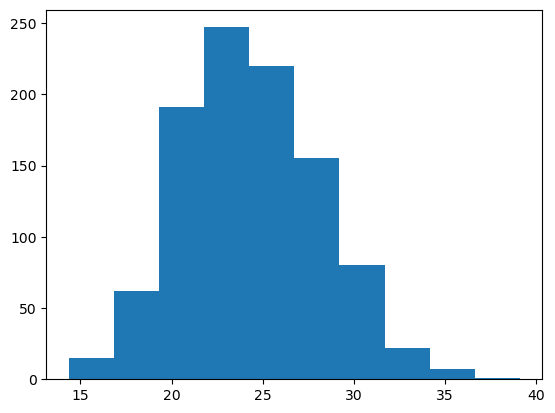

In [15]:
print('Average (over reps) of the average (over time within simulation) for unsheltered queue is: ' + str(sum(output['unsheltered_q_avg'])/number_reps))
plot = sim.plot_hist(output['unsheltered_q_avg'], 10)

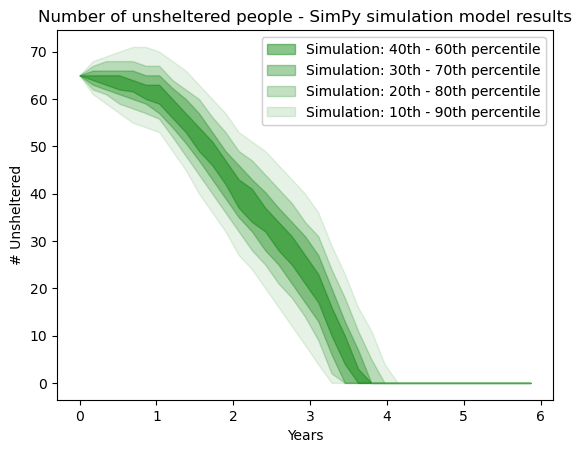

In [16]:
fig, ax = sim.create_fanchart(output['unsheltered_q_over_time'])

We now check these outputs against the Simio output previously obtained (see test_queueing_model notebook for details). First we get the output from the Simio model, and then we plot the empirical CDFs of the size of the unsheltered queue after one, two and three years of simulation time. 

In [17]:
# imports
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# read simulation data from file
data_sim = []
unsheltered_initial = initial_demand - initial_capacity['shelter'] - initial_capacity['housing'] # to add to the first row of each data file

for i in range(1000):
    run = i+1
    file_name = 'data/simio_outputs/2023-08-11-SimpleModelAC_IncV2_no_absorbing_state/SimOutput_Experiment1_Scenario 4_Rep' + str(run) + '.xlsx'
    sim_out = pd.read_excel(file_name)
    sim_out.columns = ['housing_capacity', 'shelter_capacity', 'housing_occupied', 'shelter_occupied', 'num_unsheltered', 'last_shetler_time']
    data_sim.append(np.array(pd.concat([pd.Series([unsheltered_initial]), sim_out['num_unsheltered'][1:]])))
    
data_sim = np.array(data_sim).T

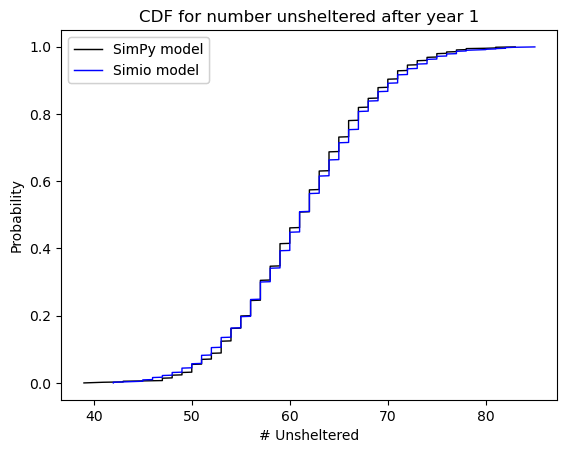

In [18]:
fig, ax = sim.compare_cdf(output['unsheltered_q_over_time'], data_sim,1)

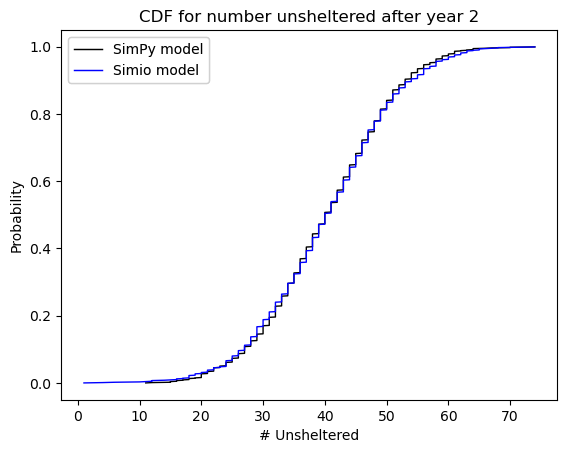

In [19]:
fig, ax = sim.compare_cdf(output['unsheltered_q_over_time'], data_sim,2)

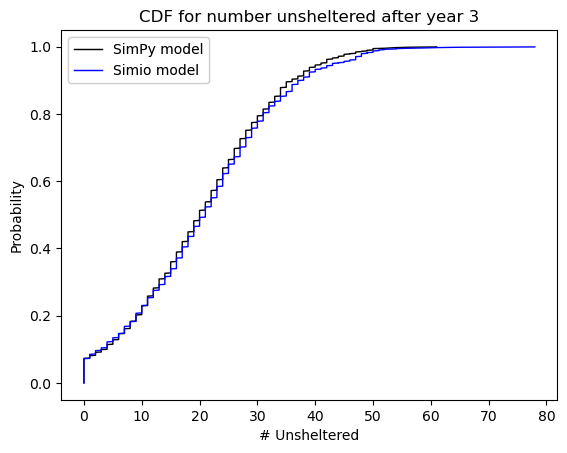

In [20]:
fig, ax = sim.compare_cdf(output['unsheltered_q_over_time'], data_sim,3)

### Next steps

* Kolmogorov-Smirnoff tests to compare the SimPy and Simio model outputs
* CDF plots and K-S tests to compare the SimPy and analyical queueing model outputs
* Model re-entries to the system as re-entries rather than adding a constant rate to each arrival rate
* Generate a relatively small-scale discrete-valued solution space (e.g. building rates of 20, 40 or 60 new houses per year and 0, 10 or 20 new shelter units, each year for four years - giving a solution space of size 3^8 = ~6,000 solutions) and try a Ranking & Selection algorithm